# Damped bead on a rotating Hoop

From Sec. 3.5 in Strogatz.  Full equation:
$$
m R \ddot{\phi} = -b \dot{\phi} - m g \sin \phi + m R^2 \omega \sin \phi \cos \phi
$$

If we introduce nondimensionalizations
$$
\gamma = \frac{R \omega^2}{g} \hspace{2cm} \epsilon = \frac{m^2 g R}{b^2}  \hspace{2cm} T = \frac{b}{mg},
$$
the equation becomes
$$
\epsilon \frac{d^2 \phi}{d \tau^2} = - \frac{d \phi}{d \tau} - \sin \phi + \gamma \sin \phi \cos \phi.
$$
For $\epsilon \ll 1$ and $\gamma = \mathcal{O}(1)$, the system is overdamped and approximately first-order.  The system undergoes a pitchfork bifurcation at $\gamma = 1$.

In [1]:
import numpy as np
import numpy.random as rng

from scipy.integrate import odeint
from scipy.optimize import minimize

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from sklearn.kernel_ridge import KernelRidge
import warnings

In [2]:
nsamples = int(100)
data = np.random.uniform(0, 1, [5, nsamples])  # [m, R, b, g, w]

m = np.random.uniform(1e-2, 1, nsamples)
R = np.random.uniform(1e-2, 4, nsamples)
b = np.random.uniform(1, 10, nsamples)
g = 9.8 + 0*np.random.random(nsamples)
w = np.random.uniform(1e-2, 4, nsamples)

eps = m**2 * g * R / b**2
gam = R * w**2 / g

# Simulate dynamics

In [3]:
def rhs(y, p):
    e, g = p
    return np.array([y[1],
                     (-y[1]-np.sin(y[0])+g*np.sin(y[0])*np.cos(y[0]))/e])

def run_sim(eps, gamma, phi0, t):
    return odeint(lambda y, t: rhs(y, [eps, gamma]), phi0, t)

In [12]:
phi0 = [1, 0]
t = np.linspace(0, 10, 200)

phi = np.zeros([nsamples, len(t)])
dphi = np.zeros([nsamples, len(t)])
for i in range(nsamples):
    y =  run_sim(eps[i], gam[i], phi0, t)
    phi[i, :] = y[:, 0]
    dphi[i, :] = y[:, 1]

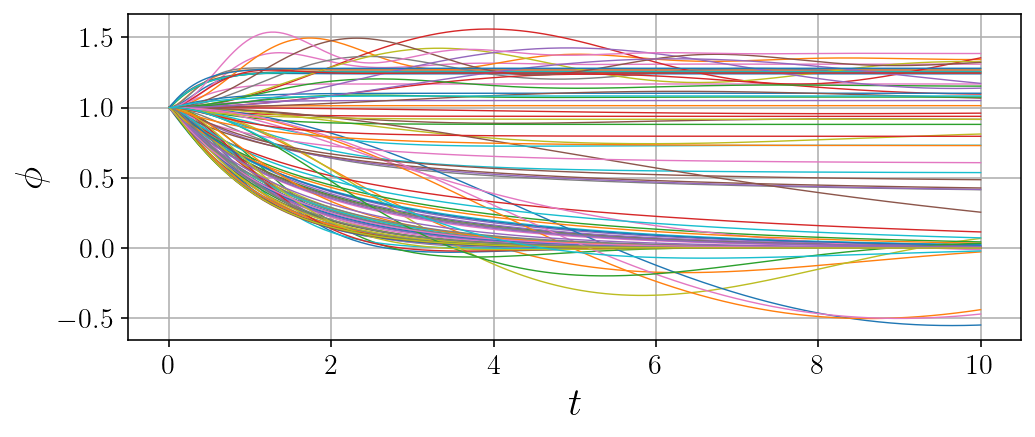

In [13]:
plt.figure(figsize=(8, 3))
plt.plot(t, phi.T, lw=0.7)
plt.xlabel('$t$')
plt.ylabel(r"$\phi$")
plt.grid()
plt.show()

# PCA on trajectories

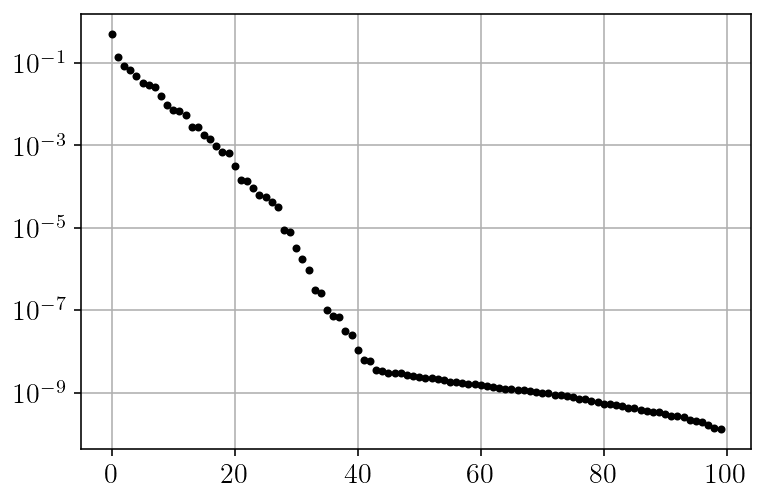

In [260]:
U, S, V = np.linalg.svd(dphi.T, full_matrices=False)
plt.semilogy((S/sum(S)), 'k.')
plt.grid()

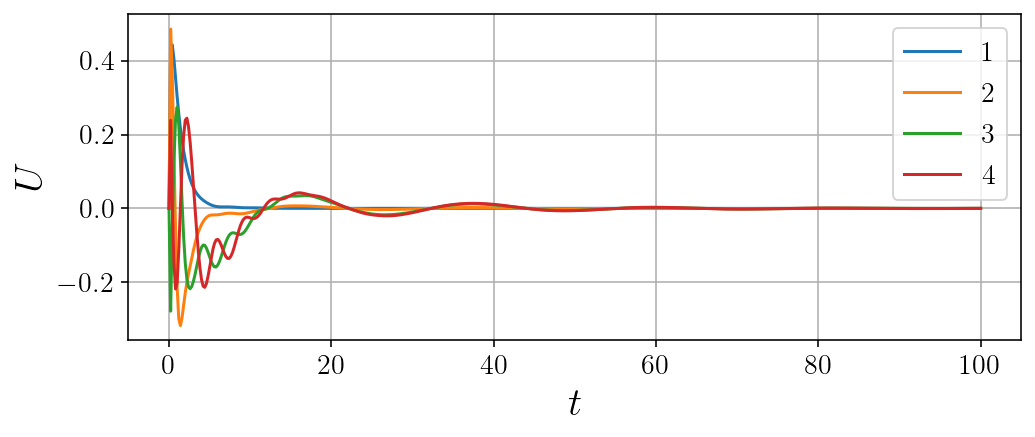

In [261]:
plt.figure(figsize=(8, 3))
plt.plot(t, U[:, :4])
plt.legend(np.arange(1, 5), fontsize=14, loc='upper right')
plt.xlabel('$t$')
plt.ylabel(r"$U$")
plt.grid()
plt.show()

Text(0, 0.5, '$\\phi^*$')

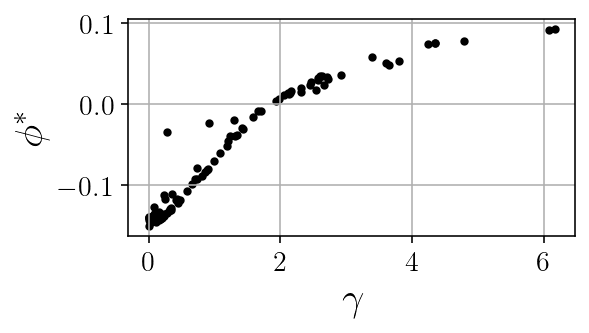

In [262]:
plt.figure(figsize=(4, 2))
plt.scatter(gam, V[0, :], c='k', s=10)
plt.xlim()
plt.grid()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\phi^*$')

Text(0, 0.5, '$\\phi^*$')

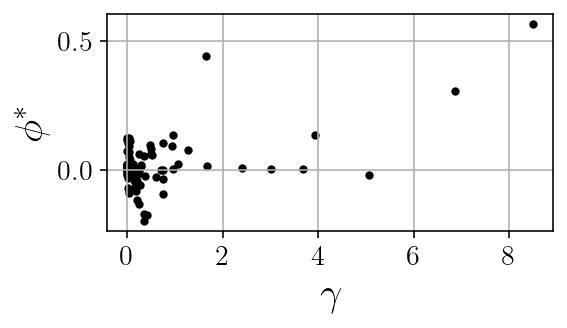

In [263]:
plt.figure(figsize=(4, 2))
plt.scatter(eps, V[2, :], c='k', s=10)
plt.xlim()
plt.grid()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\phi^*$')

### Kernel Ridge Regression

In [264]:
r=4

In [265]:
krr = KernelRidge(alpha=1e-4, kernel='rbf', gamma=10)
krr.fit(np.array([gam, eps]).T, V[:4, :].T)
krr.score(np.array([gam, eps]).T, V[:r, :].T)

0.9999948461445903

# Optimization

In [266]:
# Buckingham pi matrix
# [m, R, b, g, w]
Pi = np.array([[0, 1, 0], [1, 0, 0], [1, 1, -1], [1, 0, -2], [0, 0, -1]]).T
print(Pi)

# True vector is in the nullspace
g_vec = np.array([0, 1, 0, -1, 2])
e_vec = np.array([2, 1, -2, 1, 0])
print(Pi @ g_vec)
print(Pi @ e_vec)

[[ 0  1  1  1  0]
 [ 1  0  1  0  0]
 [ 0  0 -1 -2 -1]]
[0 0 0]
[0 0 0]


In [267]:
# Cost function from KRR
krr = KernelRidge(alpha=1e-4, kernel='rbf', gamma=10)

def loss(x, p, q, krr, l1_reg=0, dim=1):
    theta = np.exp(np.log(p) @ np.reshape(x, [p.shape[1], dim]))
    krr.fit(theta, q)
    return 1 - krr.score(theta, q) + l1_reg*np.linalg.norm(x, ord=1)

# All parameters
p = np.vstack([m, R, b, g, w]).T

In [268]:
x0 = rng.randn(Pi.shape[1], 2)

def constr(x):
    return (Pi @ np.reshape(x, x0.shape) ).flatten()

r = 4
res = minimize(lambda x: loss(x, p, V[:r, :].T, krr, l1_reg=1e-3, dim=x0.shape[1]),
               x0,
               constraints=[{'type':'eq', 'fun': constr}],
               options={'disp': True})

print(g_vec)
print(e_vec)
x = np.reshape(res.x, x0.shape)
print(x[:, 0]/x[1, 0])
print(x[:, 1]/x[1, 1])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0023968550970672143
            Iterations: 36
            Function evaluations: 416
            Gradient evaluations: 36
[ 0  1  0 -1  2]
[ 2  1 -2  1  0]
[-1.68691046e-04  1.00000000e+00  1.68691046e-04 -1.00016869e+00
  2.00016869e+00]
[ 1.99964390e+00  1.00000000e+00 -1.99964390e+00  9.99643902e-01
  3.56097616e-04]


In [269]:
# Re-run with random initialization

min_loss = 1e8
ntrials = 10
r = 20

for i in range(ntrials):
    try:
        x0 = rng.randn(Pi.shape[1], 2)
        res = minimize(lambda x: loss(x, p, V[:r, :].T, krr, l1_reg=1e-3, dim=x0.shape[1]),
                       x0,
                       constraints=[{'type':'eq', 'fun': constr}],
                       options={'disp': False})
        
        if res.fun < min_loss:
            x = np.reshape(res.x, x0.shape)
            min_loss = res.fun
            print(min_loss)
        
    # If optimization fails, try again
    except ValueError:
        pass


print(g_vec)
print(e_vec)
print(x[:, 0]/x[1, 0])
print(x[:, 1]/x[1, 1])

0.005379537541429444
0.004328345919256721
0.003567275363286509
[ 0  1  0 -1  2]
[ 2  1 -2  1  0]
[ 2.45209572  1.         -2.45209572  1.45209572 -0.45209572]
[-7.07297786e-04  1.00000000e+00  7.07297786e-04 -1.00070730e+00
  2.00070730e+00]


# Cross-validation

In [270]:
from sklearn.model_selection import train_test_split

# Cost function from KRR
def loss(x, p, q, krr,
         l1_reg=0, dim=1, seed=0, test_size=0.10):
    theta = np.exp(np.log(p) @ np.reshape(x, [p.shape[1], dim]))
    X_train, X_test, y_train, y_test = train_test_split(
        theta, q, test_size=test_size, random_state=seed
        )
    #print(x)
    krr.fit(X_train, y_train)
    #krr.fit(theta, q)
    return 1 - krr.score(X_test, y_test) + l1_reg*np.linalg.norm(x, ord=1)

# All parameters
p = np.vstack([m, R, b, g, w]).T

In [271]:
# Test KRR
krr = KernelRidge(alpha=1e-4, kernel='rbf', gamma=10)
r = 4

loss(np.vstack([e_vec, g_vec]).T, p, V[:r, :].T, krr, seed=0, dim=2, test_size=0.1)

0.750957779720838

In [ ]:
krr = KernelRidge(alpha=1e-4, kernel='rbf', gamma=10)
x0 = rng.randn(Pi.shape[1], 2)

def constr(x):
    return (Pi @ np.reshape(x, x0.shape) ).flatten()

r = 20
seed = 0
res = minimize(lambda x: loss(x, p, V[:r, :].T, krr,
                         l1_reg=1, dim=x0.shape[1], seed=seed, test_size=0.1),
               x0,
               constraints=[{'type':'eq', 'fun': constr}],
               options={'disp': True})


print(g_vec)
print(e_vec)
x = np.reshape(res.x, x0.shape)
print(x[:, 0]/x[1, 0])
print(x[:, 1]/x[1, 1])

In [ ]:
# Re-run with random initialization

min_loss = 1e8

ntrials = 100
r = 20
test_size = 0.1
seed = 0
l1_reg = 0.01

krr = KernelRidge(alpha=1e-4, kernel='rbf', gamma=10)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(ntrials):
        try:
            x0 = rng.randn(Pi.shape[1], 2)
            res = minimize(lambda x: loss(x, p, V[:r, :].T, krr,
                                     l1_reg=l1_reg, dim=x0.shape[1],
                                     seed=seed, test_size=test_size),
                           x0,
                           constraints=[{'type':'eq', 'fun': constr}],
                           options={'disp': False})

            if res.fun < min_loss:
                x = np.reshape(res.x, x0.shape)
                min_loss = res.fun
                print(min_loss)

        # If optimization fails, try again
        except ValueError:
            pass


print(g_vec)
print(e_vec)
print(x[:, 0]/x[1, 0])
print(x[:, 1]/x[1, 1])

In [246]:
x

array([[-8.99000673e-06,  7.52817527e-07],
       [-5.38021079e-05,  4.92867404e-06],
       [ 8.99000673e-06, -7.52817527e-07],
       [ 4.48121012e-05, -4.17585651e-06],
       [-9.86142091e-05,  9.10453055e-06]])

In [206]:
# Re-run with random initialization

min_loss = 1e8
ntrials = 10
r = 20
test_size = 0.1
seed = 0
l1_reg = 1

for i in range(ntrials):
    try:
        x0 = rng.randn(Pi.shape[1], 2)
        res = minimize(lambda x: loss(x, p, V[:r, :].T, krr,
                                 l1_reg=l1_reg, dim=x0.shape[1],
                                 seed=seed, test_size=test_size),
                       x0,
                       constraints=[{'type':'eq', 'fun': constr}],
                       options={'disp': True})
        
        if res.fun < min_loss:
            x = np.reshape(res.x, x0.shape)
            min_loss = res.fun
            print(min_loss)
        
    # If optimization fails, try again
    except ValueError:
        pass


print(g_vec)
print(e_vec)
print(x[:, 0]/x[1, 0])
print(x[:, 1]/x[1, 1])

<ipython-input-178-e5d501b48921>:6: RuntimeWarning: overflow encountered in exp
  theta = np.exp(np.log(p) @ np.reshape(x, [p.shape[1], dim]))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.954672555809393
            Iterations: 41
            Function evaluations: 490
            Gradient evaluations: 41
0.954672555809393


/usr/local/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:311: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:312: RuntimeWarning: invalid value encountered in add
  distances += YY


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9538151367167639
            Iterations: 64
            Function evaluations: 759
            Gradient evaluations: 64
0.9538151367167639


<ipython-input-178-e5d501b48921>:6: RuntimeWarning: overflow encountered in exp
  theta = np.exp(np.log(p) @ np.reshape(x, [p.shape[1], dim]))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9530922710264982
            Iterations: 31
            Function evaluations: 387
            Gradient evaluations: 31
0.9530922710264982
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9549456232210557
            Iterations: 34
            Function evaluations: 412
            Gradient evaluations: 34


<ipython-input-178-e5d501b48921>:6: RuntimeWarning: overflow encountered in exp
  theta = np.exp(np.log(p) @ np.reshape(x, [p.shape[1], dim]))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9548869429461835
            Iterations: 35
            Function evaluations: 434
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9541779464538238
            Iterations: 49
            Function evaluations: 608
            Gradient evaluations: 49
[ 0  1  0 -1  2]
[ 2  1 -2  1  0]
[-7.48705049e-07  1.00000000e+00  7.48705049e-07 -1.00000075e+00
  2.00000075e+00]
[ 2.00381624  1.         -2.00381624  1.00381624 -0.00381624]
